# MNIST DATASET


imports

In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

Global tunnings

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

### Import dataset

Build PyTorch Data loaders

In [4]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './file/',
        train=True,
        download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Normalization: Mean = 0.1307 ; Std deviation = 0.3081;
        ])
    ),
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './file/',
        train=False,
        download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Normalization: Mean = 0.1307 ; Std deviation = 0.3081;
        ])
      ),
      batch_size=batch_size_test,
      shuffle=True,
)

#### Visualization

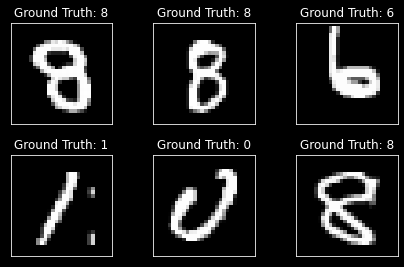

In [14]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

## Simple DNN

Parameters & Hyper Parameters

In [5]:
# Dimensions
dim_in = 28 * 28 # Width x Height (pixels)
dim_hidden = 100
dim_out = 10

# Hyper parameters
num_epochs = 10
learning_rate = 0.01
w_decay = 1e-3
momentum = 0.9

### Define network

In [7]:
class Net(nn.Module):

  def __init__(self, dim_in: int, dim_hidden: int, dim_out: int):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(dim_in, dim_hidden)
    self.fc2 = nn.Linear(dim_hidden, dim_out)

  def forward(self, x: torch.Tensor):
    x = x.view(-1, 784) # TODO: What these values?
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

Initialisation


In [ ]:
model = Net(dim_in=dim_in, dim_hidden=dim_hidden, dim_out=dim_out).to(DEVICE) # Use GPU (cuda)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=w_decay, momentum=momentum)

### Train

[epoch 0] [0/60000 (0.00%)]	Loss: 0.043901
[epoch 0] [6400/60000 (10.66%)]	Loss: 0.028823
[epoch 0] [12800/60000 (21.32%)]	Loss: 0.084504
[epoch 0] [19200/60000 (31.98%)]	Loss: 0.012950
[epoch 0] [25600/60000 (42.64%)]	Loss: 0.027837
[epoch 0] [32000/60000 (53.30%)]	Loss: 0.019982
[epoch 0] [38400/60000 (63.97%)]	Loss: 0.014823
[epoch 0] [44800/60000 (74.63%)]	Loss: 0.027633
[epoch 0] [51200/60000 (85.29%)]	Loss: 0.119017
[epoch 0] [57600/60000 (95.95%)]	Loss: 0.020298
------------------- ---------------------- -----------------
[epoch 0] Average train loss: 0.00046579402117446686
[epoch 0] Average train accuracy: 0.9935333132743835

[epoch 1] [0/60000 (0.00%)]	Loss: 0.023005
[epoch 1] [6400/60000 (10.66%)]	Loss: 0.018682
[epoch 1] [12800/60000 (21.32%)]	Loss: 0.017937
[epoch 1] [19200/60000 (31.98%)]	Loss: 0.016444
[epoch 1] [25600/60000 (42.64%)]	Loss: 0.032081
[epoch 1] [32000/60000 (53.30%)]	Loss: 0.017249
[epoch 1] [38400/60000 (63.97%)]	Loss: 0.028315
[epoch 1] [44800/60000 (74.6

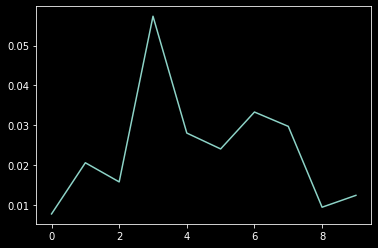

In [36]:
# train_losses = []
# train_counter = []

n_train = len(train_loader.dataset)
writer = SummaryWriter(log_dir='file/log/simple_net_train')

loss_l = []
for epoch in range(num_epochs):
    average_acc = 0
    average_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad() # Zero the gradient so it doesn't get acumulated
        output = model(data)  # Forward pass

        # Train accuracy
        y_hat = output.data.max(1, keepdim=True)[1]
        train_acc = y_hat.eq(target.data.view_as(y_hat)).sum()
        average_acc += train_acc
        train_acc = train_acc / len(target.data)

        # Update weights
        loss = criterion(output, target) # Calculates loss function
        average_loss += loss.item()
        loss.backward()   # Backpropagation
        optimizer.step()  # Update weights
        
        # Log progress
        if batch_idx % 100 == 0:
            
            n_parsed_items = batch_idx * len(data)
            progress = 100. * batch_idx / len(train_loader)
            aux = (epoch - 1) * len(train_loader) + batch_idx # TODO: What does this number mean?
            
            # train_losses.append(loss.item())
            # train_counter.append((batch_idx * batch_size_train) + ((epoch - 1) * n_train))
            
            print(f"[epoch %d] [%d/%d (%.2f%%)]\tLoss: %.6f" % (epoch, n_parsed_items, n_train, progress, loss.item()))
            writer.add_scalar('Loss/train', loss.item(), aux)
            writer.add_scalar('Accuracy/train', train_acc, aux)
        
    writer.close()
    loss_l.append(loss.item())

    print("------------------- ---------------------- -----------------")
    print(f"[epoch {epoch}] Average train loss: {average_loss / n_train}")
    print(f"[epoch {epoch}] Average train accuracy: {average_acc / n_train}\n")
          
plt.plot(loss_l)


### Test

In [41]:
# test_losses = []
test_loss = 0
correct = 0

n_test = len(test_loader.dataset)

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        test_loss += criterion(output, target)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= n_test

# test_losses.append(test_loss)
accuracy = 100. * correct / n_test
print(f'\nTest set: Avg. loss: %.4f, Accuracy: %d/%d (%.2f%%)\n' % (test_loss, correct, n_test, accuracy))


Test set: Avg. loss: 0.0001, Accuracy: 9791/10000 (97.91%)



## Convolutional NN

In [ ]:
class CNN(nn.Module):
    '''
        01 channel (B&W images)
        10 classes (10 digits in the MNIST set) 
    '''

    def __init__(self, in_channels=1, num_classes=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels=10, kernel_size=5) # 2D convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) # Fully connected
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Convolution 01
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        # Convolution 02
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Fully connected 01
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        # Fully connected 02
        x = self.fc2(x)
        # Output
        return F.log_softmax(x)